In [1]:
import sqlite3
import json
import tqdm
import numpy as np

from matplotlib import pyplot as plt

In [2]:
connection = sqlite3.connect('test_repos_5_sec.db')
cursor = connection.cursor()

In [3]:
print('Count of requests: 1000')

cursor.execute('SELECT end_time - start_time FROM repos WHERE rate_limit = 0 ORDER BY start_time')
result = cursor.fetchall()
duration = np.array([i[0] for i in result])
print('\nCount of successful requests:', len(duration))
print('Duration time +- std:', np.mean(duration), '+-', np.std(duration))

cursor.execute('SELECT end_time - start_time FROM repos WHERE rate_limit = 1 ORDER BY start_time')
result = cursor.fetchall()
duration = np.array([i[0] for i in result])
print('\nCount of unsuccessful requests:', len(duration))
print('Duration time +- std:', np.mean(duration), '+-', np.std(duration))

Count of requests: 1000

Count of successful requests: 813
Duration time +- std: 3.6410969004566525 +- 0.361433343677158

Count of unsuccessful requests: 187
Duration time +- std: 0.48783645910375256 +- 0.20889688819008145


In [10]:
cursor.execute('SELECT count(*) as c FROM repos WHERE rate_limit = 0')
successful_count = cursor.fetchone()[0]

cursor.execute('SELECT count(*) as c FROM repos WHERE rate_limit = 1')
unsuccessful_count = cursor.fetchone()[0]

print('Ratio of successful requests to unsuccessful ones:', successful_count/unsuccessful_count)
print('Ratio of successful requests to all:', successful_count/(successful_count+unsuccessful_count))

Ratio of successful requests to unsuccessful ones: 4.347593582887701
Ratio of successful requests to all: 0.813


In [9]:
cursor.execute('SELECT start_time, rate_limit FROM repos WHERE rate_limit = 0 ORDER BY start_time')
temp_res_a = [i[0] for i in cursor.fetchall()]

cursor.execute('SELECT start_time, rate_limit FROM repos WHERE rate_limit = 1 ORDER BY start_time')
temp_res_b = [i[0] for i in cursor.fetchall()]

iter_tuple = (
    (temp_res_a, 'Duration of acsess:'),
    (temp_res_b,'Duration of blocking:')
)

for temp_res, name_1 in iter_tuple:
    result = []

    buf_vals = []
    prev_time = temp_res[0]
    for time in temp_res[1:]:
        if  time - prev_time >= 5.5:
            result += [np.array(buf_vals)]
            buf_vals = []
            prev_time = time
            continue

        buf_vals += [time]
        prev_time = time

    stats = []
    for i in result:
        count = len(i)
        duration = max(i) - min(i)

        stats += [(count, duration)]

    print(name_1, np.mean([i[1] for i in stats]), '+-', np.std([i[1] for i in stats]))

Duration of acsess: 42.85018297873045 +- 2.6189177333476374
Duration of blocking: 2.3383421103159585 +- 2.6303792880979393


(0.0, 1000.0)

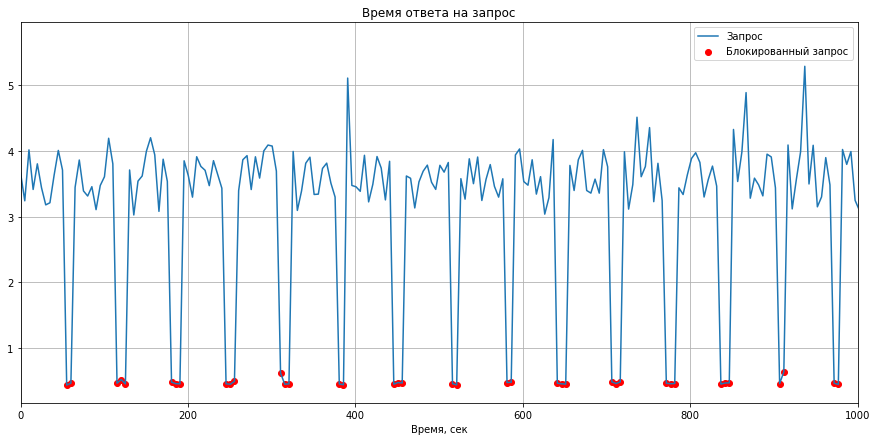

In [11]:
cursor.execute('SELECT start_time, end_time - start_time FROM repos ORDER BY start_time')
req = cursor.fetchall()
time = np.array([i[0] for i in req])
duration = [i[1] for i in req]

cursor.execute('SELECT start_time, end_time - start_time FROM repos WHERE rate_limit = 1 ORDER BY start_time')
blocked_req = cursor.fetchall()
blocked_req_time = np.array([i[0] for i in blocked_req])
blocked_req_duration = [i[1] for i in blocked_req]

blocked_req_time -= min(time)
time -= min(time)


plt.figure(figsize = (15, 7))

plt.plot(time, duration, label = 'Запрос')
plt.scatter(blocked_req_time, blocked_req_duration, c = 'r', label = 'Блокированный запрос')

plt.grid()
plt.xlabel('Время, сек')
plt.title('Время ответа на запрос')
plt.legend()
plt.xlim([0, 1000])

Changes count: 0.0 +- 0.0


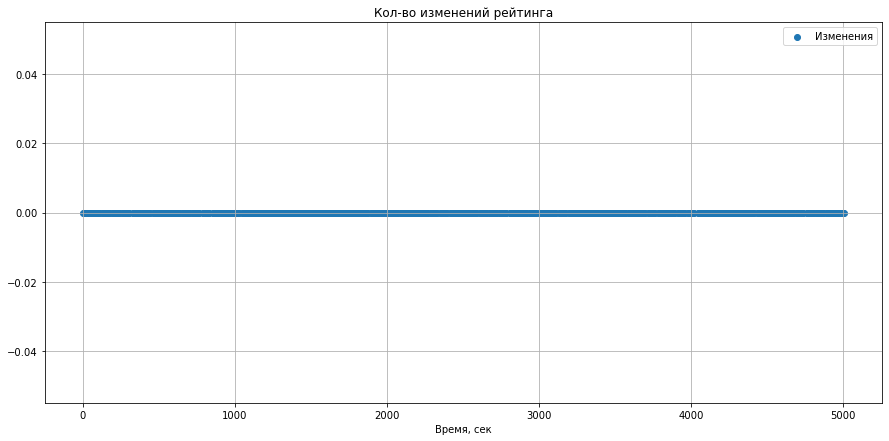

In [8]:
cursor.execute('SELECT end_time, repos FROM repos WHERE rate_limit = 0 ORDER BY start_time')
result = cursor.fetchall()
time = np.array([i[0] for i in result])
time -= min(time)

repos = [{j['id']:c_j+1 for c_j, j in enumerate(json.loads(i[1]))} for i in result]

changes = [0]

prev_repos = repos[0]
for repo in repos[1:]:
    change = 0
    for i in repo:
        if repo[i] - prev_repos[i] != 0:
            change += 1
            
    changes += [change]
    prev_repos = repo
    
print('Changes count:', np.mean(changes), '+-', np.std(changes))

plt.figure(figsize = (15, 7))

plt.scatter(time, changes, label = 'Изменения')

plt.grid()
plt.xlabel('Время, сек')
plt.title('Кол-во изменений рейтинга')
plt.legend()